In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
src = "/home/andres/data/hbmep-processed/J_SHAP/data.csv"
df = pd.read_csv(src)

In [3]:
df.shape

(16440, 44)

In [4]:
columns = ["part"]

In [5]:
df.columns

Index(['pulse_amplitude', 'pulse_train_frequency', 'pulse_period',
       'pulse_duration', 'pulse_count', 'train_delay', 'channel1_1',
       'channel1_2', 'channel1_3', 'channel1_4', 'channel2_1', 'channel2_2',
       'channel2_3', 'channel2_4', 'charge_params_1', 'charge_params_2',
       'charge_params_3', 'charge_params_4', 'bank_check', 'run', 'enabled',
       'channel_failA', 'channel_failB', 'channel_fail_comb', 'time_pulse',
       'time', 'ix_onsets', 'auc_2', 'auc_6', 'auc_5', 'auc_7', 'auc_1',
       'auc_4', 'auc_3', 'auc_8', 'channel1_laterality', 'channel1_segment',
       'channel2_laterality', 'channel2_segment', 'compound_position',
       'compound_charge_params', 'participant', 'subdir_pattern',
       'charge_param_error'],
      dtype='object')

In [6]:
file = open("/home/andres/repos/rat-mapping-paper/reports/J_SHAP/combine.pkl","rb")
combo = pickle.load(file)

In [7]:
def threshold_array(shape):
    my_dict = {
    (key[0], key[1], key[3]): value["a"].mean() for  key,value in combo.items() if key[2] == shape
    }
    keys, values = zip(*my_dict.items())
    axis0 = np.unique([key[0] for key in keys])
    axis1 = ["Deltoid", "Biceps", "Triceps", "ECR", "FCR", "ADM"][::-1]
    pos_L = np.zeros((len(axis0), len(axis1)))
    pos_M = np.zeros((len(axis0), len(axis1)))
    for key, value in zip(keys, values):
        if key[1].split("-")[0][2:] == "L":
            pos_L[np.where(axis0 == key[0])[0], np.where(np.array(axis1) == key[2][1:])[0]] = 1/value 
        elif key[1].split("-")[0][2:] == "M":
            pos_M[np.where(axis0 == key[0])[0], np.where(np.array(axis1) == key[2][1:])[0]] = 1/value 
    return(pos_L, pos_M, axis0, axis1)

In [8]:
arr = None
responses = list(set([u[3] for u in combo.keys()]))
combinations_no_response = [(c[0], c[1], c[2]) for c in combo]
combinations_no_response = set(combinations_no_response)
combinations_no_response = list(combinations_no_response)
for muscle in responses:
    arr_muscle = None

    for c in combinations_no_response:
        a = combo[(*c, muscle)]["a"]
        a = a[:, 0, 0, 0, 0]

        if arr_muscle is None:
            arr_muscle = a[:, None]
        else:
            # concatenate now
            arr_muscle = np.concatenate([arr_muscle, a[:, None]], axis=-1)

    if arr is None:
        arr = arr_muscle[:,:, None]

    else:
        arr = np.concatenate([arr, arr_muscle[:,:, None]], axis = -1) 

In [9]:
arr.shape

(4000, 320, 6)

In [ ]:
combinations_no_response

In [11]:
df[['participant','compound_position', 'compound_charge_params']].apply(tuple, axis = 1).nunique()

320

In [12]:
pmono20 = np.array([bool(re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])
pmono80 = np.array([bool(re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])
mono = np.array([bool(re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])
bip = np.array([bool(re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])

lat = np.array([bool(s[1].split("-")[1][2:] == "L") for s in combinations_no_response])
med = np.array([bool(s[1].split("-")[1][2:] == "M") for s in combinations_no_response])



In [13]:
dictBool = {}

dictBool[('lateral pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2]) and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "L") for s in combinations_no_response])
dictBool[('lateral pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "L") for s in combinations_no_response])
dictBool[('lateral bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "L") for s in combinations_no_response])
dictBool[('lateral mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "L") for s in combinations_no_response])

dictBool[('medial pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
dictBool[('medial pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
dictBool[('medial bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
dictBool[('medial mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])


In [66]:
A = arr[:,dictBool[('lateral pmono20')],:].mean(axis=0)

In [62]:
# A.reshape(-1,).shape

(192,)

In [41]:
diplot = {}

diplot[('L-M pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2]) and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])

diplot[('M-L pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2]) and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])

diplot[('ground - position mono')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])
diplot[('position - ground mono')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])

diplot[('ground - position p20')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])
diplot[('position - ground p20')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])

diplot[('ground - position p80')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])
diplot[('position - ground p80')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])

diplot[('ground - position bip')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])
diplot[('position - ground bip')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])

In [67]:
A.mean()

159.82804525509846

In [68]:
stats.sem(A.reshape(-1,))

9.19492007716287

In [14]:
value = []
for b,v in dictBool.items():
    for b1, v1 in dictBool.items():
        A = arr[:,v,:].mean(axis = 0).reshape(-1,)
        B = arr[:,v1,:].mean(axis = 0).reshape(-1,)
        tbvs, pbvs = stats.ttest_ind(B,A, alternative="less")
        if pbvs < 0.05:
            value.append(f"{b1} is more effective than {b} (p = {pbvs})")
        else: value.append(f"No significant difference for {b1} vs {b} (p = {pbvs})")

In [15]:
A = arr[:,mono,:].mean(axis = 0).reshape(-1,)
B = arr[:,bip,:].mean(axis = 0).reshape(-1,)

tbvs, pbvs = stats.ttest_ind(B,A, alternative="less")

pbvs

0.9999996519248618

In [16]:
value

['No significant difference for lateral pmono20 vs lateral pmono20 (p = 0.5)',
 'No significant difference for lateral pmono80 vs lateral pmono20 (p = 0.2488507375822367)',
 'No significant difference for lateral bip vs lateral pmono20 (p = 0.13371095690032442)',
 'No significant difference for lateral mono vs lateral pmono20 (p = 0.7217150520969153)',
 'No significant difference for medial pmono20 vs lateral pmono20 (p = 0.9977754747869669)',
 'No significant difference for medial pmono80 vs lateral pmono20 (p = 0.9884524148383961)',
 'No significant difference for medial bip vs lateral pmono20 (p = 0.6939039894212642)',
 'No significant difference for medial mono vs lateral pmono20 (p = 0.9999413360281021)',
 'No significant difference for lateral pmono20 vs lateral pmono80 (p = 0.7511492624177634)',
 'No significant difference for lateral pmono80 vs lateral pmono80 (p = 0.5)',
 'No significant difference for lateral bip vs lateral pmono80 (p = 0.3396069029131209)',
 'No significant 

In [17]:
a = set(u[1] for u in combinations_no_response)
a

{'-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L'}

In [18]:
C61 = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C6" in s[1].split("-")[0][0:] or "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C71 = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C7" in s[1].split("-")[0][0:] or "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C81 = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C8" in s[1].split("-")[0][0:] or "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C62 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C6" in s[1].split("-")[0][0:] or "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C72 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C7" in s[1].split("-")[0][0:] or "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C82 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C8" in s[1].split("-")[0][0:] or "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C63 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C6" in s[1].split("-")[0][0:] or "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C73 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C7" in s[1].split("-")[0][0:] or "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C83 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C8" in s[1].split("-")[0][0:] or "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C64 = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C6" in s[1].split("-")[0][0:] or "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C74 = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C7" in s[1].split("-")[0][0:] or "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C84 = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C8" in s[1].split("-")[0][0:] or "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])

In [19]:
C = arr[:,C71,:].mean(axis = 0).reshape(-1,)
D = arr[:,C81,:].mean(axis = 0).reshape(-1,)

tbvs, pbvs = stats.ttest_ind(C,D, alternative="less")

pbvs

2.9022671961365798e-12

In [20]:
C74.sum()

48

In [21]:
arr[:,mask,:].shape

NameError: name 'mask' is not defined

In [ ]:
L, M = threshold_array("20-0-80-25")

In [ ]:
ttest_values, pscores = stats.ttest_ind(L, M)
pscores


array([0.92528306, 0.38606512, 0.67930961, 0.50053072, 0.51280737,
       0.35147554])

Graphing if we want group comparison

In [ ]:
def graph_arr(charge):
    L, M, subject, muscle = threshold_array(charge)
    sub_meanS = np.median(L, axis=0)
    rowS = np.vsplit(L,len(subject))
    rowS = [i.tolist() for i in rowS]
    sub_meanL = np.median(M, axis=0)
    rowL = np.vsplit(M,len(subject))
    rowL = [i.tolist() for i in rowL]
    for xval_ind, xval in enumerate(rowS):
        # plt.plot(xval[0], muscle, linestyle='dashed', marker=".", markersize=20, alpha =0.3, color = "pink")
        plt.plot(sub_meanS,muscle, color = "red", linestyle='dashed', marker=".", markersize=20, label="Lateral" if xval_ind == 0 else None)
        # plt.legend('Lateral')
    for xval_ind,xval in enumerate(rowL):
        # plt.plot(xval[0], muscle, linestyle='dashed', marker=".", markersize=25, alpha =0.3, color = "blue")
        plt.plot(sub_meanL,muscle, color = "black", linestyle='dashed', marker=".", markersize=20, label="Medial" if xval_ind == 1 else None)
        # plt.legend('Medial')
    plt.yticks(weight ='bold',style = 'italic')
    plt.xlabel('Efficacy')
    plt.legend()
    plt.show()
    

In [ ]:
graph_arr("20-0-80-25")

## Rostral Caudal

In [ ]:
a

{'-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L'}

In [ ]:
C67b = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C76b = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C78b = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C87b = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C67m = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C76m = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C78m = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C87m = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C67p80 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C76p80 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C78p80 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C87p80 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C67p20 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C76p20 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C78p20 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C87p20 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])


In [ ]:
rost = arr[:,C67m,:].mean(axis = 0)

rost.shape

(5, 6)

In [ ]:
np.sort(np.array(combinations_no_response)[C67m], axis=0)

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [4, 4, 4]])

In [ ]:
t = np.array(combinations_no_response)[C76m]

t

array([['amap08', 'C7L-C6L', '50-0-50-100'],
       ['amap06', 'C7L-C6L', '50-0-50-100'],
       ['amap04', 'C7L-C6L', '50-0-50-100'],
       ['amap05', 'C7L-C6L', '50-0-50-100'],
       ['amap07', 'C7L-C6L', '50-0-50-100']], dtype='<U11')

In [ ]:
np.matrix.argsort(t, axis=0)

array([[2, 0, 0],
       [3, 1, 1],
       [1, 2, 2],
       [4, 3, 3],
       [0, 4, 4]])

In [ ]:
ind = np.argsort(t, axis=0)

In [ ]:
np.take_along_axis(t, ind, axis=0)

array([['amap04', 'C7L-C6L', '50-0-50-100'],
       ['amap05', 'C7L-C6L', '50-0-50-100'],
       ['amap06', 'C7L-C6L', '50-0-50-100'],
       ['amap07', 'C7L-C6L', '50-0-50-100'],
       ['amap08', 'C7L-C6L', '50-0-50-100']], dtype='<U11')

In [ ]:
t[np.matrix.argsort(t, axis=0)]

array(['A', 'B', 'C', 'D'], dtype='<U1')

In [ ]:
t = np.array(["C", "A", "B", "D"])

np.argsort(t)

array([1, 2, 0, 3])

In [ ]:
np.sort(t)

array(['A', 'B', 'C', 'D'], dtype='<U1')

In [ ]:
t[np.argsort(t)]

array(['A', 'B', 'C', 'D'], dtype='<U1')

In [ ]:
np.sort(np.array(combinations_no_response)[C76m], axis=0)


array([['amap04', 'C7L-C6L', '50-0-50-100'],
       ['amap05', 'C7L-C6L', '50-0-50-100'],
       ['amap06', 'C7L-C6L', '50-0-50-100'],
       ['amap07', 'C7L-C6L', '50-0-50-100'],
       ['amap08', 'C7L-C6L', '50-0-50-100']], dtype='<U11')

In [ ]:
caud = arr[:,C76m,:].mean(axis = 0)
caud.shape

(5, 6)

In [ ]:
np.sort(np.array(combinations_no_response)[C76m])


array([['50-0-50-100', 'C7L-C6L', 'amap08'],
       ['50-0-50-100', 'C7L-C6L', 'amap06'],
       ['50-0-50-100', 'C7L-C6L', 'amap04'],
       ['50-0-50-100', 'C7L-C6L', 'amap05'],
       ['50-0-50-100', 'C7L-C6L', 'amap07']], dtype='<U11')

In [ ]:
rost.shape

(30,)

In [ ]:
rost_combinations[rost_ind[..., 0], :]

array([['amap04', 'C6L-C7L', '50-0-50-100'],
       ['amap05', 'C6L-C7L', '50-0-50-100'],
       ['amap06', 'C6L-C7L', '50-0-50-100'],
       ['amap07', 'C6L-C7L', '50-0-50-100'],
       ['amap08', 'C6L-C7L', '50-0-50-100']], dtype='<U11')

In [ ]:
db = {}

db['C67b'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C76b'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C78b'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C87b'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C67m'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C76m'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C78m'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C87m'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C67p80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C76p80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C78p80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C87p80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C67p20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C76p20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C78p20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C87p20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

In [ ]:
#L vs M
db['C67b'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and (s[1].split("-")[0][0:] < s[1].split("-")[1][0:])) for s in combinations_no_response])


In [40]:
"C5M" < "C6L" 

True

In [ ]:
rost = arr[:,db['C76m'],:].mean(axis = 0)
rost.shape

(5, 6)

In [ ]:
tlist = []

for k, v in db.items(): 
    for k1, v1 in db.items():
        rost = arr[:,v,:].mean(axis = 0)
        caud = arr[:,v1,:].mean(axis = 0)
        # print(k, rost.shape, caud.shape, k[3:] == k1[3:])
        if (rost.shape == caud.shape) and (k[3:] == k1[3:] and k!= k1):
            # print(k, k1)
            temp1_combinations = np.array(combinations_no_response)[v]
            temp1_ind = np.argsort(temp1_combinations, axis=0)
            rost = rost[temp1_ind[:, 0], :]

            temp_combinations = np.array(combinations_no_response)[v1]
            temp_ind = np.argsort(temp_combinations, axis=0)
            caud = caud[temp_ind[:, 0], :]

            rost = rost.reshape(-1,)
            caud = caud.reshape(-1,)
            a = stats.ttest_rel(rost,caud, alternative="less")
            tlist.append(f"The p value for {k} vs {k1} is {a.pvalue}")
        else: continue


In [ ]:
tlist

['The p value for C67b vs C76b is 0.4203729359673106',
 'The p value for C76b vs C67b is 0.5796270640326894',
 'The p value for C78b vs C87b is 0.964256564673948',
 'The p value for C87b vs C78b is 0.03574343532605192',
 'The p value for C67m vs C76m is 0.9418045017055068',
 'The p value for C76m vs C67m is 0.058195498294493206',
 'The p value for C78m vs C87m is 0.00033960400336569447',
 'The p value for C87m vs C78m is 0.9996603959966344',
 'The p value for C67p80 vs C76p80 is 0.9644580424533974',
 'The p value for C76p80 vs C67p80 is 0.03554195754660254',
 'The p value for C78p80 vs C87p80 is 0.0018929713203402383',
 'The p value for C87p80 vs C78p80 is 0.9981070286796597',
 'The p value for C67p20 vs C76p20 is 0.13975131480136166',
 'The p value for C76p20 vs C67p20 is 0.8602486851986384',
 'The p value for C78p20 vs C87p20 is 0.9499706323692025',
 'The p value for C87p20 vs C78p20 is 0.050029367630797475']

In [ ]:
a = stats.ttest_rel(rost,caud, alternative="less")
a.pvalue


NameError: name 'rost' is not defined

## Ground 

In [ ]:
mybool = {}
mybool[('ground - position mono')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])
mybool[('position - ground mono')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])

mybool[('ground - position p20')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])
mybool[('position - ground p20')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])

mybool[('ground - position p80')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])
mybool[('position - ground p80')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])

mybool[('ground - position bip')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])
mybool[('position - ground bip')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])

In [37]:
l = set(k[1] for k in combo.keys())
l

{'-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L'}

In [ ]:
gvalue = []
for b,v in mybool.items():
    for b1, v1 in mybool.items():
        A = arr[:,v,:].mean(axis = 0).reshape(-1,)
        B = arr[:,v1,:].mean(axis = 0).reshape(-1,)
        tbvs, pbvs = stats.ttest_ind(B,A, alternative="less")
        if pbvs < 0.05:
            gvalue.append(f"{b1} is more effective than {b} (p = {pbvs})")
        else: gvalue.append(f"No significant difference for {b1} vs {b} (p = {pbvs})")

In [ ]:
gvalue

['No significant difference for ground - position mono vs ground - position mono (p = 0.5)',
 'No significant difference for position - ground mono vs ground - position mono (p = 0.9999999999999388)',
 'No significant difference for ground - position p20 vs ground - position mono (p = 0.5524870400308437)',
 'No significant difference for position - ground p20 vs ground - position mono (p = 0.9999999999972042)',
 'No significant difference for ground - position p80 vs ground - position mono (p = 0.9999996434502291)',
 'No significant difference for position - ground p80 vs ground - position mono (p = 0.42577787404621154)',
 'No significant difference for ground - position bip vs ground - position mono (p = 0.8182051477061763)',
 'No significant difference for position - ground bip vs ground - position mono (p = 0.5771767024003044)',
 'ground - position mono is more effective than position - ground mono (p = 6.115689694642182e-14)',
 'No significant difference for position - ground mono 

## Plotting Data

In [44]:
diplot = {}

diplot[('L-M pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2]) and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])

diplot[('M-L pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2]) and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])

diplot[('ground - position mono')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])
diplot[('position - ground mono')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])

diplot[('ground - position p20')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])
diplot[('position - ground p20')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])

diplot[('ground - position p80')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])
diplot[('position - ground p80')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])

diplot[('ground - position bip')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])
diplot[('position - ground bip')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])

diplot['R-C mono'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and (s[1].split("-")[0][0:] < s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['R-C bip'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and (s[1].split("-")[0][0:] < s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['R-C pmono20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and (s[1].split("-")[0][0:] < s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['R-C pmono80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and (s[1].split("-")[0][0:] < s[1].split("-")[1][0:])) for s in combinations_no_response])

diplot['C-R mono'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and (s[1].split("-")[0][0:] > s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['C-R bip'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and (s[1].split("-")[0][0:] > s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['C-R pmono20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and (s[1].split("-")[0][0:] > s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['C-R pmono80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and (s[1].split("-")[0][0:] > s[1].split("-")[1][0:])) for s in combinations_no_response])


In [74]:
my_plotdict = {}
for k, v in diplot.items():
    my_plotdict[k] = arr[:,v,:].mean(axis=0).reshape(-1)

In [85]:
my_plotdict.keys()

dict_keys(['L-M pmono20', 'L-M pmono80', 'L-M bip', 'L-M mono', 'M-L pmono20', 'M-L pmono80', 'M-L bip', 'M-L mono', 'ground - position mono', 'position - ground mono', 'ground - position p20', 'position - ground p20', 'ground - position p80', 'position - ground p80', 'ground - position bip', 'position - ground bip', 'R-C mono', 'R-C bip', 'R-C pmono20', 'R-C pmono80', 'C-R mono', 'C-R bip', 'C-R pmono20', 'C-R pmono80'])

In [119]:
x = ['Rostral vs Caudal', 'Ground Position', 'Lateral vs Medial']

yrc = []
ygp = []
ylm = []
y=[yrc, ygp, ylm]

for k, v in my_plotdict.items():
    if "L" in k:
        v = v.mean()
        ylm.append(v)
    elif "R" in k:
        v = v.mean()
        yrc.append(v)
    elif "ground" in k:
        v = v.mean()
        ygp.append(v)
    else: continue

df = pd.DataFrame(list(zip(x, y)),
               columns =['Name', 'val'])

,Name,val
0,Rostral vs Caudal,"[163.81516150041188, 154.80783514944113, 159.6..."
1,Ground Position,"[142.725186865306, 264.9952665955407, 144.6358..."
2,Lateral vs Medial,"[187.2012449903469, 179.60953944164476, 171.43..."


In [121]:
type = ["Rostral vs Caudal" for _ in  range(len(yrc))] + ["Ground Position" for _ in  range(len(ygp))] + ["Lateral vs Medial" for _ in  range(len(ylm))]
vals = yrc + ygp + ylm

df = pd.DataFrame(list(zip(type, vals)),
               columns =['Name', 'val'])

In [122]:
df

,Name,val
0,Rostral vs Caudal,163.815162
1,Rostral vs Caudal,154.807835
2,Rostral vs Caudal,159.641125
3,Rostral vs Caudal,185.517177
4,Rostral vs Caudal,223.162297
5,Rostral vs Caudal,150.067799
6,Rostral vs Caudal,217.403293
7,Rostral vs Caudal,160.252974
8,Ground Position,142.725187
9,Ground Position,264.995267


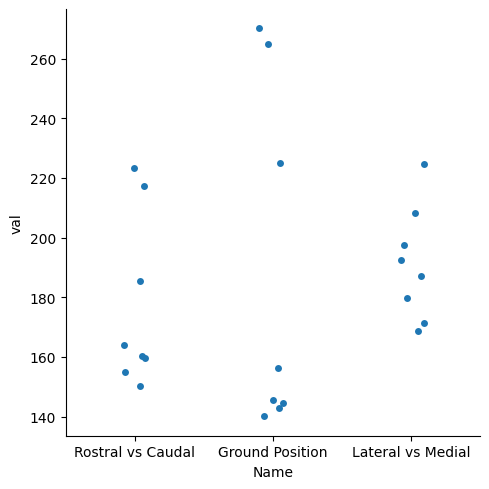

In [123]:
sns.catplot(data=df, x="Name", y="val")

In [100]:
"L-M" in "R-C bip"

False

In [104]:
"M-L" in "R-C bip"

False

In [108]:
yrc

[163.81516150041188,
 154.80783514944113,
 159.6411249153712,
 185.51717720701902,
 223.16229738622488,
 150.0677990258932,
 217.40329341421892,
 160.25297402950508]